In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

int8
[  0  68  70  72  74  78  79  86  88  90  92  97  99 100]


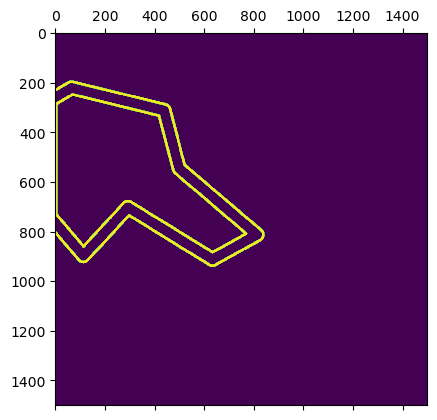

In [5]:
with open('../to_be_saved/occupancy_grid.npy', 'rb') as f:
    occupancy_grid = np.load(f)

print(occupancy_grid.dtype)

print(np.unique(occupancy_grid))

plt.matshow(occupancy_grid)

Binary split down the occupancy map, only drive thorugh places were we know the car would fit through any configuration

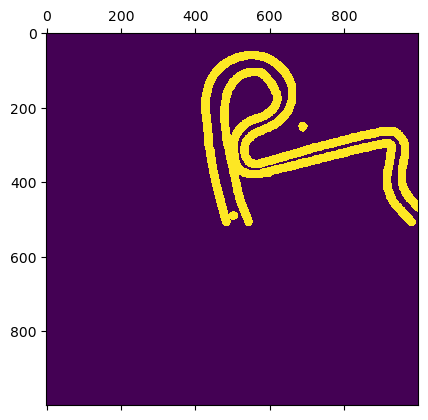

In [5]:
occupancy_grid_filtered = (occupancy_grid >30)*1
plt.matshow(occupancy_grid_filtered)


In [6]:
def classify_points(x_start, y_start, binary_occupancy_grid: np.ndarray):
    """"Classifies all points in map into categories depending on start point
    Categories:
    0) Non reachable
    1) reachable
    2) belonging to line bordering (is also fatal but extra class)
    3) fatal
    """
    
    # convert all fatal points to value 3
    reachability_grid = binary_occupancy_grid.copy() * 3

    # check start point is valid
    assert x_start >=0 and y_start >= 0 and y_start < reachability_grid.shape[0] and x_start < reachability_grid.shape[1]
    assert reachability_grid[y_start, x_start] != 2

    # start recursiv fnding
    recursive_find_new_points(x_start, y_start, reachability_grid)

    return reachability_grid


def recursive_find_new_points(x,y, reachability_grid: np.ndarray):
    assert reachability_grid[y,x] == 0

    # Step 1 -> set current point as reachable
    reachability_grid[y, x] = 1

    # Step 2 -> go in every direction and start again
    # defin helper function
    def check_new_point(x, y, reachability_grid: np.ndarray):
        # we are inbound
        if x>=0 and y>= 0 and y < reachability_grid.shape[0] and x < reachability_grid.shape[1]:
            if reachability_grid[y,x] == 0:
                return True
            if reachability_grid[y,x] == 3:
                # update from fatal to border
                reachability_grid[y, x] = 2
        return  False

    for x_dir in [-1, 0, 1]:
        for y_dir in [-1, 0, 1]:
            if check_new_point(x+x_dir, y+y_dir, reachability_grid):
                recursive_find_new_points(x+x_dir, y+y_dir, reachability_grid)


    

In [6]:
from collections import deque

def classify_points_non_recursive(start_point, binary_occupancy_grid: np.ndarray):
    """"Classifies all points in map into categories depending on start point
    Categories:
    0) Non reachable
    1) reachable
    2) belonging to line bordering (is also fatal but extra class)
    3) fatal
    """
    (x_start, y_start) = start_point

    # convert all fatal points to value 3
    reachability_grid = binary_occupancy_grid.copy() * 3

    # check start point is valid
    assert x_start >=0 and y_start >= 0 and y_start < reachability_grid.shape[0] and x_start < reachability_grid.shape[1]
    assert reachability_grid[y_start, x_start] != 2

    points_to_explore = deque()
    points_to_explore.append(start_point)

    while len(points_to_explore) != 0:
        # pop first element from stack and mark reachable
        (x,y) = points_to_explore.pop()
        reachability_grid[y,x] = 1

        # find new points and add to queue
        new_points = find_new_points((x,y), reachability_grid)
        for point in new_points:
            points_to_explore.append(point)
    
    return reachability_grid

def find_new_points(start_point, reachability_grid: np.ndarray):
    (x,y) = start_point
    assert reachability_grid[y,x] == 1

    points_of_iterst = []
    for x_dir in [-1, 0, 1]:
        for y_dir in [-1, 0, 1]:
            new_point = (x+x_dir, y+y_dir)
            if check_point(new_point, reachability_grid):
                points_of_iterst.append(new_point)
    return points_of_iterst


def check_point(point, reachability_grid: np.ndarray):
    (x,y) = point
    # we are inbound
    if x>=0 and y>= 0 and y < reachability_grid.shape[0] and x < reachability_grid.shape[1]:
        if reachability_grid[y,x] == 0:
            return True
        if reachability_grid[y,x] == 3:
            # update from fatal to border
            reachability_grid[y, x] = 2
    return  False   





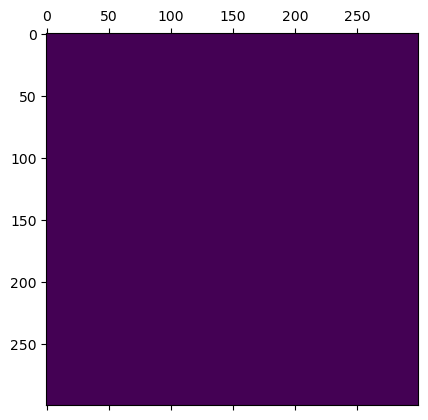

In [8]:
sys.getrecursionlimit()
sys.setrecursionlimit(20000)
occupancy_grid_filtered.shape

occupancy_grid_filtered_reshaped = occupancy_grid_filtered[700:1000, 300:600]

plt.matshow(occupancy_grid_filtered_reshaped)

In [1]:

reachbility_grid = classify_points_non_recursive((130, 150), occupancy_grid_filtered_reshaped)
plt.matshow(reachbility_grid)

np.unique(reachbility_grid)

NameError: name 'classify_points_non_recursive' is not defined

Implement Simple A star finder to get shortest distance between points

In [25]:
import heapq

def heuristic(a, b):
    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)

def backsolve_path(end, came_from):
    print("backsolve_path")
    current = end
    path = []
    while current in came_from:
        path.append(current)
        current = came_from[current]
    return path

def check_new_point(point, reachability_map: np.ndarray):
    if point[0] < 0 or point[0] > reachability_map.shape[1]:
        return False
    if point[1] < 0 or point[1] > reachability_map.shape[0]:
        return False
    if reachability_map[point[1], point[0]] != 1:
        return False
    
    return True

def a_star(start, goal, reachability_map: np.ndarray):
    start = (start[1], start[0])
    goal=(goal[1], goal[0])

    assert reachability_map[start] == 1 and reachability_map[goal] == 1

    # allow moves in all directions
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    
    open_heap = []
    closed_set = set()

    came_from = {}
    
    # add initial point to open list
    gscore = {start: 0}
    fscore={start: heuristic(start, goal)}

    heapq.heappush(open_heap, (fscore[start], start))

    while open_heap:
        current = heapq.heappop(open_heap)[1]

        # reached goal -> backwards calculate path
        if current == goal:
            return backsolve_path(current, came_from)

        # Continue path finding
        closed_set.add(current)

        # go over all neighbors
        for i, j in neighbors:
            neighbor = current[0]+i, current[1]+j

            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            
            if not check_new_point((neighbor[1], neighbor[0]), reachability_map):
                continue
            
            if neighbor in closed_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
            
            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in open_heap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                
                heapq.heappush(open_heap, (fscore[neighbor], neighbor))


backsolve_path


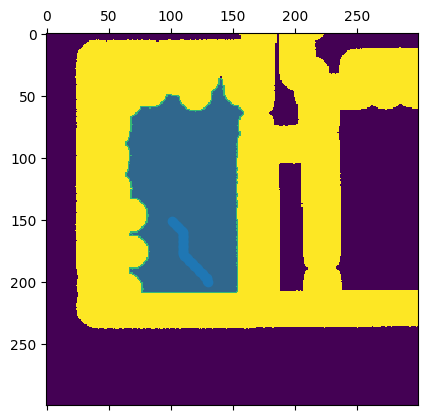

In [ ]:
path = a_star((100,150), (130,200), reachbility_grid)

plt.matshow(reachbility_grid)
plt.scatter([p[1] for p in path], [p[0] for p in path])

I now want to find the center line of any given racetrack


The first step is to extract the individual lines bordering the racetrack

In [8]:
def extract_individual_lines(classified_grid: np.ndarray):
    lines_grid = ((classified_grid == 2) * 1).copy()

    lines = []

    while True:
        reamining_line_points = np.argwhere(lines_grid == 1)
        if not len(reamining_line_points):
            break

        start_point = reamining_line_points[0]
        start_point = (start_point[1], start_point[0])
        line = []
        recursive_find_new_points_on_line(start_point, line, lines_grid)
        lines.append(line)

    return lines

def recursive_find_new_points_on_line(point, line, lines_grid: np.ndarray):
    x,y = point[0], point[1]
    assert lines_grid[y,x] == 1

    # Append pont to line
    line.append(point)

    # mark point as already belonging to line
    lines_grid[y, x] = 0

    # Step 2 -> go in every direction and start again
    # defin helper function
    def check_new_point(x, y, reachability_grid: np.ndarray):
        # we are inbound
        if x>=0 and y>= 0 and y < reachability_grid.shape[0] and x < reachability_grid.shape[1]:
            if lines_grid[y,x] == 1:
                return True
        return  False

    for x_dir in [-1, 0, 1]:
        for y_dir in [-1, 0, 1]:
            if check_new_point(x+x_dir, y+y_dir, lines_grid):
                recursive_find_new_points_on_line((x+x_dir, y+y_dir), line, lines_grid)

        


In [7]:
def extract_outer_lines_non_recursive(classified_grid: np.ndarray):
    lines_grid = ((classified_grid == 2) * 1).copy()
    lines = []

    while True:
        reamining_line_points = np.argwhere(lines_grid == 1)
        if not len(reamining_line_points):
            break

        start_point = reamining_line_points[0]
        start_point = (start_point[1], start_point[0])
        line = extract_line_segment(start_point, lines_grid)
        lines.append(line)
    
    return lines

        

def extract_line_segment(start_point, lines_grid: np.ndarray):
    line = []
    points_to_explore = deque()
    points_to_explore.append(start_point)

    def check_new_point(point, lines_grid: np.ndarray):
        (x,y) = point
        # we are inbound
        if x>=0 and y>= 0 and y < lines_grid.shape[0] and x < lines_grid.shape[1]:
            if lines_grid[y,x] == 1:
                return True
        return  False

    while points_to_explore:
        # pop first element from stack and mark as belonging to a line
        (x,y) = points_to_explore.pop()
        line.append((x,y))
        lines_grid[y,x] = 0

        

        # iterate over all bordering points to continue line
        for x_dir in [-1, 0, 1]:
            for y_dir in [-1, 0, 1]:
                new_point = (x+x_dir, y+y_dir)
                if check_new_point(new_point, lines_grid):
                    points_to_explore.append(new_point)
    return line

The second step is then to find a center line between both outer lines

In [22]:
def get_middle_line(outer_line1, outer_line2):
    middle_line = []
    for point_1 in outer_line1:
        min_distance = 1e12
        min_point = None
        for point_2 in outer_line2:
            distance = (point_1[0] - point_2[0])**2 + (point_1[1] - point_2[1])**2
            if distance < min_distance:
                min_distance = distance
                min_point = point_2
        middle_x = point_1[0] + round(0.5*(min_point[0] - point_1[0]))
        middle_y = point_1[1] + round(0.5*(min_point[1] - point_1[1]))
        middle_line.append((middle_x, middle_y))
        
    return middle_line

Example with racetrack extracted from image

(760, 935)


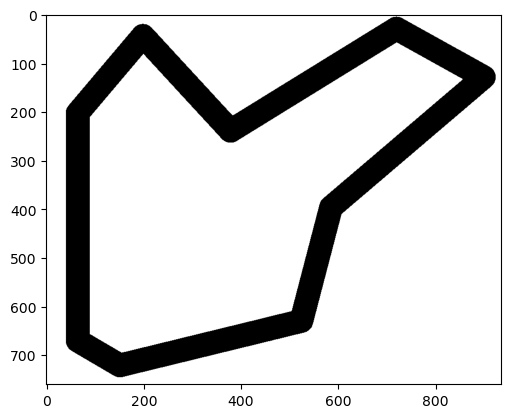

In [31]:
import cv2

img = cv2.imread("./track_3.jpeg", cv2.IMREAD_GRAYSCALE)
shape_rescaled = (img.shape[0] // 2, img.shape[1] //2)
print(shape_rescaled)
img = cv2.resize(img, (shape_rescaled[1], shape_rescaled[0]))

_, img_binarized = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
img_binarized = (img_binarized == 255) * 1


plt.imshow(img_binarized, 'gray',vmin=0,vmax=1)

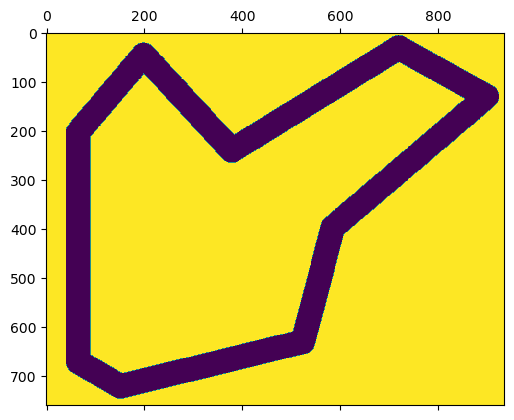

In [32]:
classified_grid = classify_points_non_recursive((200, 700), img_binarized)
plt.matshow(classified_grid)

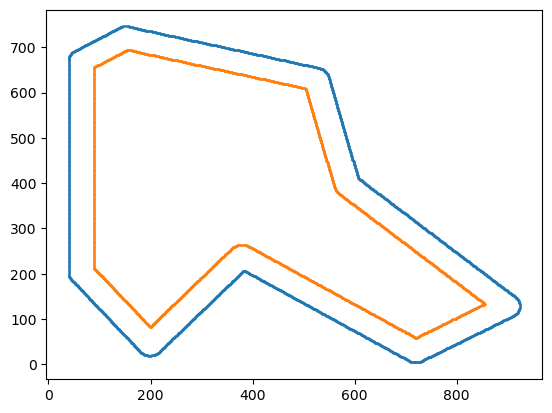

In [33]:
lines = extract_outer_lines_non_recursive(classified_grid)

for line in lines:
    plt.scatter([p[0] for p in line], [p[1] for p in line], s=0.2)
    

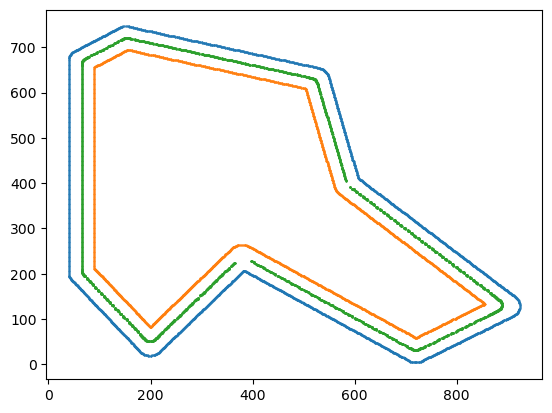

In [34]:
middle_line = get_middle_line(lines[0], lines[1])

for line in lines:
    plt.scatter([p[0] for p in line], [p[1] for p in line], s=0.1) 

plt.scatter([p[0] for p in middle_line], [p[1] for p in middle_line], s=0.2)


# A star to find minimum distance path between two points

backsolve_path


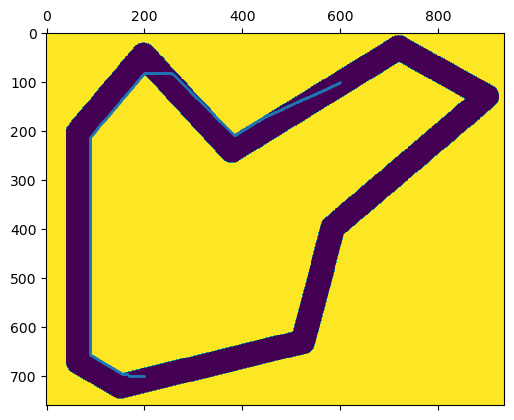

In [35]:
path = a_star((200,700), (600,100), classified_grid)
plt.matshow(classified_grid)

plt.scatter([p[1] for p in path], [p[0] for p in path], s=0.5)

Create World from Image

In [36]:
#! Code Heaviliy insipired by https://github.com/leekwoon/map2world

import numpy as np 
import cv2 
import os
import yaml
from lxml import etree as ET
from copy import copy



class WorldGenerator(object):
    kernel_size = 4 # for 2D map image preprocessing
    def __init__(self, binary_height_map, out_dir, config={"resolution": 0.050000}):
        """"
        binary_height_map should be a map where 0 stands for area free and 1 for area occupied
        """
        self.config = config
        self.out_dir = out_dir
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        
        self.map_original = binary_height_map * 255
        self.map_flipped = np.flip(self.map_original.astype(np.float), 0)


        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self.kernel_size, self.kernel_size))
        self.map_flipped = cv2.morphologyEx(self.map_flipped, cv2.MORPH_CLOSE, kernel)


         # center world in frame
         #! Play around with these parameters
        # self.resolution = 0.050000
        self.resolution = config["resolution"]
        self.origin = np.array([-self.resolution * self.map_flipped.shape[1] / 2 , -self.resolution * self.map_flipped.shape[0] / 2])
        #self.origin = np.array([0,-self.resolution * self.map_flipped.shape[0]])
        #print(self.origin)

        

    def write_basics(self):
        sdf = ET.Element("sdf",version="1.6")
        world = ET.SubElement(sdf, "world", name="default")
        # global light source
        include = ET.SubElement(world, 'include')
        uri = ET.SubElement(include, 'uri')
        uri.text = 'model://sun'
        # ground plane
        include = ET.SubElement(world, 'include')
        uri = ET.SubElement(include, 'uri')
        uri.text = 'model://ground_plane'
        # ode
        physics = ET.SubElement(world, 'physics', type='ode')
        real_time_update_rate = ET.SubElement(physics, 'real_time_update_rate')
        real_time_update_rate.text = '1000.0'
        max_step_size = ET.SubElement(physics, 'max_step_size')
        max_step_size.text = '0.001'
        real_time_factor = ET.SubElement(physics, 'real_time_factor')
        real_time_factor.text = '1'
        ode = ET.SubElement(physics, 'ode')
        solver = ET.SubElement(ode, 'solver')
        type = ET.SubElement(solver, 'type')
        type.text = 'quick'
        iters = ET.SubElement(solver, 'iters')
        iters.text = '150'
        precon_iters = ET.SubElement(solver, 'precon_iters')
        precon_iters.text = '0'
        sor = ET.SubElement(solver, 'sor')
        sor.text = '1.400000'
        use_dynamic_moi_rescaling = ET.SubElement(solver, 'use_dynamic_moi_rescaling')
        use_dynamic_moi_rescaling.text = '1'
        constraints = ET.SubElement(ode, 'constraints')
        cfm = ET.SubElement(constraints, 'cfm')
        cfm.text = '0.00001'
        erp = ET.SubElement(constraints, 'erp')
        erp.text = '0.2'
        contact_max_correcting_vel = ET.SubElement(constraints, 'contact_max_correcting_vel')
        contact_max_correcting_vel.text = '2000.000000'
        contact_surface_layer = ET.SubElement(constraints, 'contact_surface_layer')
        contact_surface_layer.text = '0.01000'

        # scene
        scene = ET.SubElement(world, 'scene')
        ambient = ET.SubElement(scene, 'ambient')
        ambient.text = '0.4 0.4 0.4 1'
        background = ET.SubElement(scene, 'background')
        background.text = '0.7 0.7 0.7 1'
        shadows = ET.SubElement(scene, 'shadows')
        shadows.text = 'true'

        # gui
        gui = ET.SubElement(world, 'gui', fullscreen='0')
        camera = ET.SubElement(gui, 'camera', name='user_camera')
        pose = ET.SubElement(camera, 'pose')
        pose.text = '0.0 0.0 17.0 -1.5708 1.5708 0'
        view_controller = ET.SubElement(camera, 'view_controller')
        view_controller.text ='orbit'

        return sdf, world

    def generate_v_wall(self, parent, x, y, length, id):
        collision = ET.SubElement(parent, 'collision', name='obstacle_{}'.format(id))
        pose = ET.SubElement(collision, 'pose')
        pose.text = '{} {} 0 0 0 1.5708'.format(str(x), str(y))
        geometry = ET.SubElement(collision, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))

        visual = ET.SubElement(parent, 'visual', name='obstacle_{}'.format(id))
        pose = ET.SubElement(visual, 'pose')
        pose.text = '{} {} 0 0 0 1.5708'.format(str(x), str(y))
        geometry = ET.SubElement(visual, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))
        material = ET.SubElement(visual, 'material')
        script = ET.SubElement(material, 'script')
        uri = ET.SubElement(script, 'uri')
        uri.text = 'file://media/materials/scripts/gazebo.material'
        name = ET.SubElement(script, 'name')
        name.text = 'Gazebo/Grey'
        ambient = ET.SubElement(material, 'ambient')
        ambient.text = '1 1 1 1'

    def generate_h_wall(self, parent, x, y, length, id):
        collision = ET.SubElement(parent, 'collision', name='obstacle_{}'.format(id))
        pose = ET.SubElement(collision, 'pose')
        pose.text = '{} {} 0 0 0 0'.format(str(x), str(y))
        geometry = ET.SubElement(collision, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))

        visual = ET.SubElement(parent, 'visual', name='obstacle_{}'.format(id))
        pose = ET.SubElement(visual, 'pose')
        pose.text = '{} {} 0 0 0 0'.format(str(x), str(y))
        geometry = ET.SubElement(visual, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))
        # cylinder = ET.SubElement(geometry, 'cylinder')
        material = ET.SubElement(visual, 'material')
        script = ET.SubElement(material, 'script')
        uri = ET.SubElement(script, 'uri')
        uri.text = 'file://media/materials/scripts/gazebo.material'
        name = ET.SubElement(script, 'name')
        name.text = 'Gazebo/Grey'
        ambient = ET.SubElement(material, 'ambient')
        ambient.text = '1 1 1 1'
  
    def is_v_wall_type(self, r, c, gridmap):
        """
            Return True if it is belong to vertical wall ...

            This function helps to reduce the number of walls to generate
        """

        vl = 0 # expected vertical length
        rr = r
        cc = c
        while rr<self.map_flipped.shape[0] and cc<self.map_flipped.shape[1] and self.map_flipped[rr][cc] == 255:
            rr += 1
            vl += 1
            
        hl = 0 # expected horizontal length
        rr = r
        cc = c
        while rr<self.map_flipped.shape[0] and cc<self.map_flipped.shape[1] and self.map_flipped[rr][cc] == 255:
            cc += 1
            hl += 1
        return vl > hl

    def generate_map(self):
      
        #transformed_map = np.flip(self.map_original.T, (0,1))
        transformed_map = self.map_original
        map_inverted = abs(255-transformed_map)
        cv2.imwrite(os.path.join(self.out_dir, "map.pgm"), map_inverted)

        yaml_file_content={
            "image": "map.pgm",
            "resolution": self.config["resolution"],
            "origin": [-self.resolution * transformed_map.shape[1] / 2, -self.resolution * transformed_map.shape[0] / 2, 0],
            "negate": 0,
            "occupied_thresh": 0.65,
            "free_thresh": 0.196
        }

        with open(os.path.join(self.out_dir, "map.yaml"), 'w') as outfile:
            yaml.dump(yaml_file_content, outfile, default_flow_style=False)




    def generate(self):
        sdf, world = self.write_basics()

        model = ET.SubElement(world, 'model', name='obstacle')
        static = ET.SubElement(model, 'static')
        static.text = '1'
        pose = ET.SubElement(model, 'pose', frame='')
        pose.text = '0 0 0 0 0 0'
        link = ET.SubElement(model, 'link', name='obstacle')
        
        parent = link

        flag = copy(self.map_flipped) # 255 -> need to build wall, 0 -> already ...

        wall_count = 0
        while True:
            idxs = np.argwhere(flag == 255)
            if len(idxs) == 0:
                break

            wall_count += 1

            start_r, start_c = idxs[0]
                
            h_wall = False
            v_wall = False
            end_r = start_r
            end_c = start_c
            # if self.map_flipped[end_r + 1][end_c] == 255 :
            if self.is_v_wall_type(start_r, start_c, self.map_flipped):
                v_wall = True
                while end_r<self.map_flipped.shape[0] and end_c<self.map_flipped.shape[1] and self.map_flipped[end_r][end_c] == 255:
                    flag[end_r][end_c] = 0
                    end_r += 1
                center_x = self.origin[0] + int((start_c + end_c) / 2) * self.resolution
                center_y = self.origin[1] + int((start_r + end_r) / 2) * self.resolution
                l = (end_r - start_r) * self.resolution
                self.generate_v_wall(link, center_x, center_y, l, wall_count)
            elif self.map_flipped[end_r][end_c + 1] == 255:
                h_wall = True
                while  end_r<self.map_flipped.shape[0] and end_c<self.map_flipped.shape[1] and self.map_flipped[end_r][end_c] == 255:
                    flag[end_r][end_c] = 0
                    end_c += 1
                center_x = self.origin[0] + int((start_c + end_c) / 2) * self.resolution
                center_y = self.origin[1] + int((start_r + end_r) / 2) * self.resolution
                l = (end_c - start_c) * self.resolution
                self.generate_h_wall(link, center_x, center_y, l, wall_count)
            else:
                flag[end_r][end_c] = 0
                continue
            print('[{} idxs remained], wall_count={}, center_x={}, center_y={}, l={}'.format(len(idxs), wall_count, center_x, center_y, l))

        tree = ET.ElementTree(sdf)
        tree.write(os.path.join(self.out_dir, "gazebo_world.world"), pretty_print=True)

        self.generate_map()

In [37]:
binary_heightmap = (classified_grid  == 2)*1
print(binary_heightmap)

world_generator = WorldGenerator(binary_heightmap, './out')
world_generator.generate()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[6797 idxs remained], wall_count=1, center_x=-15.774999999999999, center_y=-18.3, l=0.8500000000000001
[6780 idxs remained], wall_count=2, center_x=-16.225, center_y=-18.25, l=0.2
[6776 idxs remained], wall_count=3, center_x=-15.275, center_y=-18.25, l=0.25
[6771 idxs remained], wall_count=4, center_x=-16.375, center_y=-18.2, l=0.15000000000000002
[6768 idxs remained], wall_count=5, center_x=-15.075, center_y=-18.2, l=0.25
[6763 idxs remained], wall_count=6, center_x=-16.475, center_y=-18.15, l=0.15000000000000002
[6760 idxs remained], wall_count=7, center_x=-14.875, center_y=-18.15, l=0.25
[6755 idxs remained], wall_count=8, center_x=-16.575, center_y=-18.1, l=0.15000000000000002
[6752 idxs remained], wall_count=9, center_x=-14.674999999999999, center_y=-18.1, l=0.25
[6747 idxs remained], wall_count=10, center_x=-16.625, center_y=-18.05, l=0.1
[6745 idxs remained], w

/tmp/ipykernel_61539/2150270348.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.map_flipped = np.flip(self.map_original.astype(np.float), 0)


[6607 idxs remained], wall_count=46, center_x=-18.175, center_y=-17.15, l=0.15000000000000002
[6604 idxs remained], wall_count=47, center_x=-10.774999999999999, center_y=-17.15, l=0.25
[6599 idxs remained], wall_count=48, center_x=-18.275, center_y=-17.1, l=0.15000000000000002
[6596 idxs remained], wall_count=49, center_x=-10.575, center_y=-17.1, l=0.25
[6591 idxs remained], wall_count=50, center_x=-18.325, center_y=-17.05, l=0.1
[6589 idxs remained], wall_count=51, center_x=-10.375, center_y=-17.05, l=0.25
[6584 idxs remained], wall_count=52, center_x=-18.425, center_y=-17.0, l=0.15000000000000002
[6581 idxs remained], wall_count=53, center_x=-10.174999999999999, center_y=-17.0, l=0.25
[6576 idxs remained], wall_count=54, center_x=-18.525, center_y=-16.95, l=0.15000000000000002
[6573 idxs remained], wall_count=55, center_x=-9.975, center_y=-16.95, l=0.25
[6568 idxs remained], wall_count=56, center_x=-18.625, center_y=-16.9, l=0.15000000000000002
[6565 idxs remained], wall_count=57, ce

In [ ]:
def get_gazebo_point(point, height_map: np.ndarray, resolution=0.05):

    x_transformed = (point[0] - height_map.shape[1] / 2)*resolution
    y_transformed = ( height_map.shape[0] / 2 -point[1] )*resolution

    return (x_transformed,y_transformed)

In [ ]:
get_gazebo_point((200,0), binary_heightmap)
get_gazebo_point((700,0), binary_heightmap)

NameError: name 'get_gazebo_point' is not defined